In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from xgboost import to_graphviz
from xgboost import plot_importance

#IMPORT DATA - MAKE SURE THIS IS CORRECT!!!
dataset = 'COMBINED'
#path = "D:/MASTERS/IMPACT_DATA.csv"
#path = "D:/MASTERS/IMPACT_DATA_2020_2.csv"
path = "D:/MASTERS/IMPACT_DATA_COMBINED_SWAP.csv"
raw_data = pd.read_csv(path) #AS pandas Dataframe

#different input parameters in dictionary, for easily changable combinations of features
input_variable_combination = {}
input_variable_combination['resultants'] = ['peak rot acc resultant','peak lin acc resultant','peak rot vel resultant',]
input_variable_combination['components'] = ['peak x rot acc','peak x lin acc','peak x rot vel',
                                            'peak y rot acc','peak y lin acc','peak y rot vel',
                                            'peak z rot acc','peak z lin acc','peak z rot vel']
input_variable_combination['rotational_components'] = ['peak x rot acc','peak x rot vel',
                                                       'peak y rot acc','peak y rot vel',
                                                       'peak z rot acc','peak z rot vel']
input_variable_combination['resultant_rotational_acceleration'] = ['peak rot acc resultant']
input_variable_combination['resultant_rotational_velocity'] = ['peak rot vel resultant']
y_output_variable = ['Strain 90th%', 'Strain rate 90th%']

In [5]:
#CHOOOSE FEATURES
x_feature_set = 'resultants'# change this 'rotational_components', 'components', 'resultants' 
#OR FOR SINGLE LINEAR REGRESSION: resultant_rotational_velocity & resultant_rotational_acceleration
features = input_variable_combination[x_feature_set]
x_feature_set_array = ['resultants','rotational_components','components'] # if you want to put it in a for loop

In [ ]:
#set features for MULTIPLE LINEAR REGRESSION 1/2

features = input_variable_combination[x_feature_set]
print('Multiple linear regression with:')
print('inputs/features:', features )
print('outputs: strain 90th%, strain rate 90th%')
print('for', dataset,'dataset')

#simple example of linear regression
#X_train, X_test, ys_train, ys_test = train_test_split(X, ys, test_size=0.2, random_state=4)
#print(X_train, ys_train)
#model = LinearRegression()
#model.fit(X_train, ys_train)
#ys_pred = model.predict(X_test) #predicting the values

In [ ]:
#MULTIPLE LINEAR REGRESSION with 2/2
#K-fold cross validation

X = raw_data[features] #features as defined above
Y_output = ['Strain 90th%','Strain rate 90th%']

#initiating the titles of the output to be saved
results_metric_list = ['Y','R-squared','Adjusted R-squared','Mean Squared Error','Root Mean Squared Error','Features','Coefficients'] #need to account for coefficients
results = {} #creating a empty dictionary to save results
for output_metric in results_metric_list:
    results[output_metric] = []

#defining k-fold
splits = 5
kf = KFold(n_splits=splits, shuffle=True, random_state=3) # initialising k-fold with 5 splits, equivalent to 80:20 test train split

for value in Y_output:
    #setting y to strain or strain rate
    y = raw_data[value]
        
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index] #iloc - integer location indexing for pandas Dataframes 
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test) #predicting the values for

        #append results to dictionary
        results['Y'].append(y.name)
        results['R-squared'].append(r2_score(y_test, y_predict))
        #calculating adjusted r2
        adj_r2 = 1 - (1 - r2_score(y_test, y_predict)) * (len(y_test) - 1)/((len(y_test) - len(features) - 1))
                
        results['Adjusted R-squared'].append(adj_r2)
        results['Mean Squared Error'].append(mean_squared_error(y_test, y_predict))
        results['Root Mean Squared Error'].append((mean_squared_error(y_test, y_predict)**0.5))

        #plotting the line against the data (single feature ONLY)
        #plt.scatter(X, y, color="black")
        #plt.plot(X_test, y_predict, color="blue", linewidth=3)
        #plt.show()

        #creating plots comparing predicted vs fe predicted.
        #plt.figure(figsize=(10, 6))
        #plt.scatter(y_test, y_predict, color='blue', edgecolor='k', alpha=0.7)
        #plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linewidth=2)
        #plt.xlabel('FE simulated '+ value)
        #plt.ylabel('Linear regression predicted values')
        #plt.title('FE vs Linear Regression predictions')
        #plt.show()
        
        # Create Bland-Altman plot
        # Calculate mean and difference
        #mean_measurements = np.mean([y_predict, y_test], axis=0)
        #difference_measurements = y_predict - y_test
        #mean_diff = np.mean(difference_measurements)
        #std_diff = np.std(difference_measurements)

        #plt.figure(figsize=(10, 6))
        #plt.scatter(mean_measurements, difference_measurements, alpha=0.5)
        #plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
        #plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='Upper LOA')
        #plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='Lower LOA')
        #plt.xlabel('Mean of Measurements')
        #plt.ylabel('Difference of Measurements')
        #plt.title('Bland-Altman Plot')
        #plt.legend()
        #plt.show()


#add final coefficients as an example.
coefficients = model.coef_
for value in coefficients:
    results['Coefficients'].append(value)
for value in features:
    results['Features'].append(value)
for i in range(12-len(input_variable_combination[x_feature_set])): #will break if you change number of folds
    results['Coefficients'].append('Null')
    results['Features'].append('Null')

#adding the mean values to the results
results['Y'].append('strain mean')
results['Y'].append('strain rate mean')
for value in results_metric_list[1:5]:
    print(value)
    results[value].append(sum(results[value][0:5])/splits) # mean for strain k-folds
    results[value].append(sum(results[value][5:10])/splits) # mean for strain rate k-folds
print(results)
#saving results as a csv
df = pd.DataFrame(results)
#df.to_csv('D:/MASTERS/Linear_regression_results/Linear_regression_results_COMBINED_'+ x_feature_set +'.csv', index=False)
df.to_csv('D:/MASTERS/Linear_regression_results/Linear_regression_results_'+ dataset +'_' + x_feature_set +'.csv', index=False)

XGBOOST - default parameters

In [ ]:
#XGBOOST 1/3
#SETUP
raw_data = pd.read_csv(path) #AS pandas Dataframe
#removing values that arent used
raw_data.drop(['Impact label','Type'], axis=1, inplace=True) #inplace means it doesnt make a copy

#CHOOSE INPUT/OUTPUTS
features = input_variable_combination[x_feature_set]
print('XGBoost with:')
print('inputs:', features)
print('outputs: strain 90th%, strain rate 90th%')
print('for',dataset, 'dataset')


In [ ]:
#XGBOOST 2/3
#WITH K-fold method (instead of repeated random splits) 
print('running xgboost for',dataset, 'dataset')
for set in x_feature_set_array:
    features = input_variable_combination[set]
    X = raw_data[features]
    results_feature_list = ['Y','R-squared','Adjusted R-squared','Mean Squared Error','Root Mean Squared Error']
    #print(X)
    #create dictionary for data:
    results = {}
    for value in results_feature_list:
        results[value] = []
    #results['Features'] = np.array(X.columns)

    #defining k-fold
    splits = 5
    kf = KFold(n_splits=splits, shuffle=True, random_state=3) # initialising k-fold with 5 splits, equivalent to 80:20 test train split

    #running for strain, strain rate in 5 random states
    for output_value in y_output_variable:
        #setting raw_data to strain then strain rate
        y = raw_data[output_value]

        print('running for', output_value)
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index] #iloc - integer location indexing for pandas Dataframes
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            #print(train_index)
            #print(test_index)

            xgboost_model = xgb.XGBRegressor() #creating a shell xgboost regression model
            xgboost_model.fit(X_train, y_train, verbose=True) #fitting the model to the training data
            y_predict = xgboost_model.predict(X_test)#predicting outputs in test dataset

            #append results to dictionary
            results['Y'].append(y.name)
            results['R-squared'].append(r2_score(y_test, y_predict))
            #calculating adjusted r2
            adj_r2 = 1 - (1 - r2_score(y_test, y_predict)) * (len(y_test) - 1)/((len(y_test) - len(features) - 1))
            
            results['Adjusted R-squared'].append(adj_r2)
            results['Mean Squared Error'].append(mean_squared_error(y_test, y_predict))
            results['Root Mean Squared Error'].append((mean_squared_error(y_test, y_predict)**0.5))
            
            #plotting the importance of features for this trained model:
            #plot_importance(xgboost_model)

    #adding the mean values to the results
    results['Y'].append('strain mean')
    results['Y'].append('strain rate mean')
    for value in results_feature_list[1:]:
        results[value].append(sum(results[value][0:5])/splits) # mean for strain k-folds
        results[value].append(sum(results[value][5:10])/splits) # mean for strain rate k-folds

    #save dictionary to csv
    results_df = pd.DataFrame(results)
    results_df.to_csv('D:/MASTERS/XGBOOST_results/xgb_'+ set + '_k_fold_results_' + dataset + '.csv', index=False)

    print(results)
    print('for feature set:',set)
print(xgboost_model)

In [ ]:
#XGBOOST 3/3
#saving the tree diagram
xgb.to_graphviz(xgboost_model, num_trees=0, rankdir='TB')
#xgb.to_graphviz(xgboost_model, num_trees=1, rankdir='TB').render(filename="D:/MASTERS/VISUALISATIONS/XGBOOST/decision_tree_strain_rotational_components_example_2024", format='png', cleanup=True)

K- Nearest Neighbours

In [ ]:
#kNN - k nearest neighbours
x_feature_set_array = ['resultants','rotational_components','components']
print('K-nearest neighbours for ',y_output_variable)
print('with feature sets: ',x_feature_set_array)
print('will create ',len(x_feature_set_array), 'files per k')

#initialising cross validation
splits = 5
kf = KFold(n_splits=splits, shuffle=True, random_state=3) # shuffle means the data is partitioned not chronologically.
#lists the metrics to be calculated and saved in the csv
results_metric_list = ['Y','R-squared','Adjusted R-squared','Mean Squared Error','Root Mean Squared Error']

# Load dataset
df = pd.read_csv(path)

#initialising a dictionary for the parameter tuning
k_compare = {}
for value in results_metric_list:
    k_compare[value] = []
k_compare['k'] = []
k_compare['Feature set'] = []
ks = [2,3,4,5,6,7,8,9,10] # the k values to be run through (k is number of neighbours selected in knn) [!!different to k-fold!!]

#very sorry for all the nested loops
#for different ks in knn, for different feature sets, for strain/strainrate, for k-fold cross validaton
for k in ks:


    for set in x_feature_set_array:
        #setting the feture set 
        features = input_variable_combination[set] #setting the features to the listed set
        X = raw_data[features] # extracting the features from the data

        #creating an empty dictionary for the results
        results = {}
        for value in results_metric_list:
            results[value] = []

        for output_value in y_output_variable:
            #setting raw_data to strain then strain rate
            y = raw_data[output_value]
            print('running for', output_value)


            for held_index, test_index in kf.split(X, y): #held, its not 'trained'
                X_held, X_test = X.iloc[held_index], X.iloc[test_index] #iloc - integer location indexing for pandas Dataframes
                y_held, y_test = y.iloc[held_index], y.iloc[test_index]
                # Standardize the features - important as features with larger scales can dominate the distance calculation, leading to biased results.
                scaler = StandardScaler()
                X_held = scaler.fit_transform(X_held)
                X_test = scaler.transform(X_test)

                #setting parameters to the 
                knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='distance') #euclidean distance, and weighted combination by distance.
                knn_regressor.fit(X_held, y_held)

                # Make predictions
                y_predict = knn_regressor.predict(X_test)
                print(f'Mean Squared Error: {mean_squared_error(y_test, y_predict)}')
                print(f'R^2 Score: {r2_score(y_test, y_predict)}')
                adj_r2 = 1 - (1 - r2_score(y_test, y_predict)) * (len(y_test) - 1)/((len(y_test) - len(features) - 1))
                
                results['Y'].append(output_value)
                results['R-squared'].append(r2_score(y_test, y_predict))
                results['Adjusted R-squared'].append(adj_r2)
                results['Mean Squared Error'].append(mean_squared_error(y_test, y_predict))
                results['Root Mean Squared Error'].append((mean_squared_error(y_test, y_predict)**0.5))
        
        #adding the strain/strainrate labels 
        results['Y'].append('strain mean')
        results['Y'].append('strain rate mean')
        
        #for each results metric, calculate the mean of the 5-fold cross validation and input it to results for that iteration, also put it into k-compare for parameter tuning
        for value in results_metric_list[1:]:
            results[value].append(sum(results[value][0:5])/splits) # mean for strain k-folds
            results[value].append(sum(results[value][5:10])/splits) # mean for strain rate k-folds
            k_compare[value].append(sum(results[value][0:5])/splits) # mean for strain k-folds
            k_compare[value].append(sum(results[value][5:10])/splits) # mean for strain rate k-folds
        
        #adding non numerical attributes (paired with above results) ,to the k-comparison parameter tuning dictionary
        k_compare['Y'].append('strain mean')
        k_compare['Y'].append('strain rate mean')
        k_compare['k'].append(k)
        k_compare['k'].append(k)
        k_compare['Feature set'].append(set)
        k_compare['Feature set'].append(set)
        print(results)
        print(k_compare)

        #save results dictionary to csv for each k iteration and feature set
        #results_df = pd.DataFrame(results)
        #results_df.to_csv('D:/MASTERS/K-Nearest_Neighbours/knn_'+ 'k_is'+ str(k) +'_'+ set + '_k_fold_results_'+ dataset + '.csv', index=False)

    #save all results into a csv called 'parameter tuning'
    k_compare_df = pd.DataFrame(k_compare)
    k_compare_df.to_csv('D:/MASTERS/K-Nearest_Neighbours/k_parameter_tuning_'+ dataset +'_.csv', index=False)



Hyper-parameter tuning for XGBoost

In [ ]:
#XGOOST PARAMETER TUNING 1/2
#defining a function to search for optimal parameters.
# initialising k-fold with 5 splits, equivalent to 80:20 test train split
def grid_search(params, random=False):
    #xgb = xgb.XGBRegressor(booster='gbtree')
    if random: # if random is true then randomized search will be initiated.
        grid = RandomizedSearchCV(xgboost_model, params, cv=KFold(n_splits=5, shuffle=True, random_state=3), n_iter=20, n_jobs=-1)
    else:
        grid = GridSearchCV(xgboost_model, params, cv=KFold(n_splits=5, shuffle=True, random_state=3), n_jobs=-1)
    grid.fit(X, y) #fitting the input data
    best_params = grid.best_params_
    print("Best params:", best_params)
    best_score = grid.best_score_
    print("Training score: {:.3f}".format(best_score))



In [ ]:
xgboost_model = xgb.XGBRegressor()
#verify the output of this cell matches the output on the powerpoint for random state = 3
#result is baseline before parameter tuning
x_feature_set_array = ['resultants','rotational_components','components']
features = input_variable_combination[x_feature_set_array[0]] #CHANGE EACH FEATURE SET
X = raw_data[features] #make sure this is the correct feature set, as will be set to last iteration from xgboost for loops above!!
y = raw_data['Strain 90th%']
kfold = KFold(n_splits=5, shuffle=True, random_state=3)
scores = cross_val_score(xgboost_model, X, y, cv=kfold)
print('r2:', (scores))
print('r2 mean:',sum(scores)/5)

TUNING BY MOST INFLUENCE COMBINED (4 parameters)

In [ ]:
#tuning for resultants
X = raw_data[features]
y = raw_data['Strain 90th%'] ######################## CHANGE THIS
print(features)

grid_search(params={'max_depth': [3,4,5,6,7,8],
                    'lambda': [0,1,1.5,2,2.5,3,5],
                    'colsample_bynode':[0.2,0.1,0.3,0.4,0.5],
                    'subsample':[0.7,0.9,0.95,1]})

In [ ]:
#grid_search(params={'n_estimators':[0,1,2,3,4,5,6,7,8,9,10,20,21,24,25,26,50,75,100]})
#grid_search(params={'learning_rate': [0.1,0.17,0.18,0.19,0.2,0.25,0.3,0.4,0.5,0.6,0.8]})
#grid_search(params={'max_depth': [2,3,4,5,6,8,12,16]})
#grid_search(params={'gamma':[0, 0.1, 0.5, 1, 2, 5]})
#grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})
#grid_search(params={'subsample':[0.1,0.2,0.3,0.4,0.5,0.6,0.7, 0.8, 0.9, 1]})
#grid_search(params={'colsample_bytree':[0.1,0.2,0.3,0.4,0.5,0.6,0.65,0.7,0.75,0.8,0.8,0.9,1]})
#grid_search(params={'colsample_bylevel':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1]})
#grid_search(params={'colsample_bynode':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.8,0.9,1]})
#grid_search(params={'scale_pos_weight':[0,0.5,1,5,10,30,50,100]})
#grid_search(params={'max_delta_step':[0,1,2,3,4,5,6,7,8,9,10,20,100,500]})
#grid_search(params={'lambda':[0,0.25,0.5,1,1.5,2,3,4,5,6,7,8,9,10,20,100,500]})
#grid_search(params={'alpha':[0,1,2,3,4,5,6,7,8,9,10,20,100,500]})

TUNING 1 BY 1 method (7 parameters)

In [ ]:
#tuning for resultants
X = raw_data[features]
y = raw_data['Strain 90th%']
print(features)
grid_search(params={'n_estimators': [10,15,20,25,30,40,50,60,70,80,90,100]}) #default is 100 n_estimators, the number of trees in the ensemble
#21 for resultants

In [ ]:
#max_depth, n_estimators.
grid_search(params={'max_depth': [2,3,4,5,6,8,12,16],'n_estimators': [10,15,16,17,18,19,20,21,22,23,24]}) #default max depth is 6, length of the trees, reducing reduces overfitting.


In [ ]:
#Learning rate
grid_search(params={'max_depth': [2], 'n_estimators': [19],'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.8,0.9,1,2,3]}) #default is 0.3 n_estimators, the number of trees in the ensemble

In [ ]:
grid_search(params={'max_depth': [2], 'n_estimators': [19],'learning_rate': [0.3],'gamma':[0, 0.1, 0.5, 1, 2, 5]}) # default gamma is 0

In [ ]:
grid_search(params={'max_depth': [2], 'n_estimators': [19],'learning_rate': [0.3],'gamma': [0], 'min_child_weight':[1, 2, 3, 4, 5]}) # default min_child weight is 1, increasing prevents overfitting.

In [ ]:
grid_search(params={'max_depth': [2], 'n_estimators': [19],'learning_rate': [0.3],'gamma': [0], 'min_child_weight':[1],'subsample':[0.5, 0.7, 0.8, 0.9, 1]}) #default subsample is 1

In [ ]:
grid_search(params={'max_depth': [2], 'n_estimators': [19],'learning_rate': [0.3],'gamma': [0], 'min_child_weight':[1],'subsample':[1],'colsample_bytree':[0.5, 0.7, 0.8, 0.9, 1]})

BUILDING BEST XGBOOST MODELS

In [28]:
#STRAIN,resultant,combined dataset #BEST PARAMTERS, best model
best_params = {
    'colsample_bytree': 1,
    'gamma': 0,
    'learning_rate': 0.3,
    'max_depth': 2,
    'min_child_weight': 1,
    'n_estimators': 19,
    'subsample': 1}
#setup model
xgboost_strain = xgb.XGBRegressor(**best_params)
features = input_variable_combination['resultants'] #CHANGE EACH FEATURE SET #'resultants','rotational_components','components'
X = raw_data[features] #make sure this is the correct feature set, as will be set to last iteration from xgboost for loops above!!
y = raw_data['Strain rate 90th%']
kfold = KFold(n_splits=5, shuffle=True, random_state=3)
scores = cross_val_score(xgboost_strain,X, y, cv=kfold)
print('r2:', (scores))
print('r2 mean:',sum(scores)/5)
train_test_score = cross_validate(xgboost_strain,X,y,cv=kfold,return_train_score=True)
print(train_test_score)

# Extract train and test scores
train_scores = train_test_score['train_score']
test_scores = train_test_score['test_score']

# Calculate mean and sample standard deviation for train and test scores
train_mean = np.mean(train_scores)
train_std = np.std(train_scores, ddof=1)  # Sample standard deviation
test_mean = np.mean(test_scores)
test_std = np.std(test_scores, ddof=1)    # Sample standard deviation

print("Train scores:", train_scores)
print("Train mean:", train_mean)
print("Train standard deviation:", train_std)

print("Test scores:", test_scores)
print("Test mean:", test_mean)
print("Test standard deviation:", test_std)

r2: [0.80404009 0.88607566 0.94419209 0.88464911 0.87413331]
r2 mean: 0.8786180499325308
{'fit_time': array([0.00427032, 0.01603627, 0.        , 0.01664543, 0.01667285]), 'score_time': array([0.        , 0.00063658, 0.        , 0.        , 0.        ]), 'test_score': array([0.80404009, 0.88607566, 0.94419209, 0.88464911, 0.87413331]), 'train_score': array([0.94977589, 0.94178203, 0.93916135, 0.94870681, 0.94715889])}
Train scores: [0.94977589 0.94178203 0.93916135 0.94870681 0.94715889]
Train mean: 0.9453169937308331
Train standard deviation: 0.00461392164783606
Test scores: [0.80404009 0.88607566 0.94419209 0.88464911 0.87413331]
Test mean: 0.8786180499325308
Test standard deviation: 0.04993478158898546


[0]	train-rmse:0.05029	eval-rmse:0.04596
[1]	train-rmse:0.03779	eval-rmse:0.04061
[2]	train-rmse:0.02867	eval-rmse:0.03547
[3]	train-rmse:0.02274	eval-rmse:0.03260
[4]	train-rmse:0.01871	eval-rmse:0.03051
[5]	train-rmse:0.01555	eval-rmse:0.02890


[6]	train-rmse:0.01341	eval-rmse:0.02758
[7]	train-rmse:0.01132	eval-rmse:0.02736
[8]	train-rmse:0.00992	eval-rmse:0.02667
[9]	train-rmse:0.00834	eval-rmse:0.02641
[10]	train-rmse:0.00727	eval-rmse:0.02627
[11]	train-rmse:0.00632	eval-rmse:0.02621
[12]	train-rmse:0.00569	eval-rmse:0.02561
[13]	train-rmse:0.00517	eval-rmse:0.02533
[14]	train-rmse:0.00454	eval-rmse:0.02488
[15]	train-rmse:0.00431	eval-rmse:0.02457
[16]	train-rmse:0.00390	eval-rmse:0.02477
[0]	train-rmse:0.04648	eval-rmse:0.05948
[1]	train-rmse:0.03470	eval-rmse:0.04798
[2]	train-rmse:0.02589	eval-rmse:0.03972
[3]	train-rmse:0.02021	eval-rmse:0.03513
[4]	train-rmse:0.01599	eval-rmse:0.03219
[5]	train-rmse:0.01309	eval-rmse:0.03038
[6]	train-rmse:0.01114	eval-rmse:0.02989
[7]	train-rmse:0.00983	eval-rmse:0.02963
[8]	train-rmse:0.00873	eval-rmse:0.02911
[9]	train-rmse:0.00769	eval-rmse:0.02893
[10]	train-rmse:0.00642	eval-rmse:0.02897
[0]	train-rmse:0.04853	eval-rmse:0.05211
[1]	train-rmse:0.03627	eval-rmse:0.04174
[2]	trai

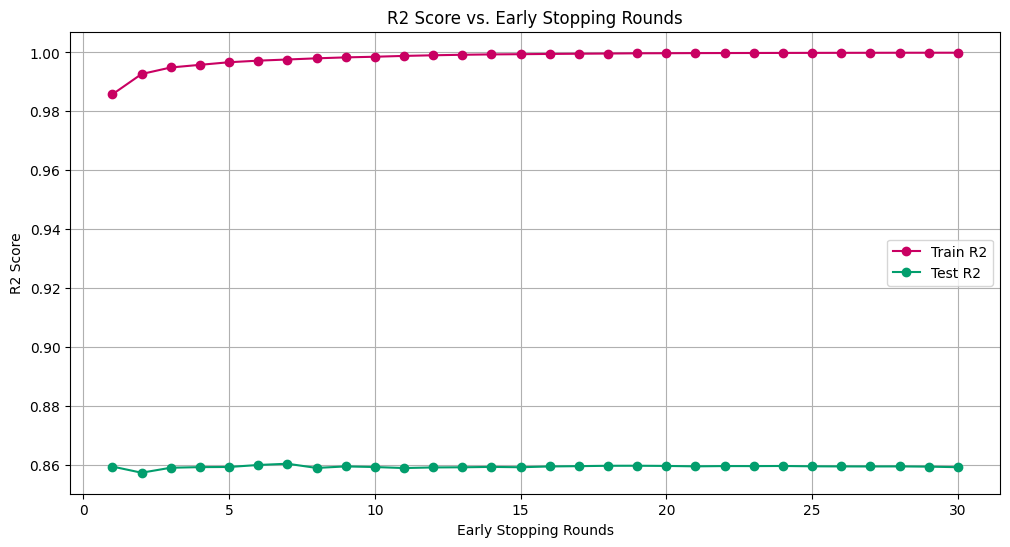

Best Train R2: 0.9999 at early stopping round 30
Best Test R2: 0.8604 at early stopping round 7


In [31]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# Best parameters from the previous tuning
best_params = { #STRAIN
    'lambda': 0.1,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'subsample': 0.7
}
#best_params = { #STRAINRATE
    #'colsample_bytree': 1,
    #'gamma': 0,
    #'learning_rate': 0.3,
    #'max_depth': 2,
    #'min_child_weight': 1,
    #'n_estimators': 19,
    #'subsample': 1}


# Setup model
features = input_variable_combination['resultants']  # Change each feature set as needed
X = raw_data[features]
y = raw_data['Strain 90th%']

kfold = KFold(n_splits=5, shuffle=True, random_state=3)

early_stopping_rounds_list = list(range(1, 31))
train_means = []
test_means = []

best_train_r2 = -np.inf
best_test_r2 = -np.inf
best_train_esr = 0
best_test_esr = 0

for esr in early_stopping_rounds_list:
    train_scores = []
    test_scores = []
    
    for train_index, val_index in kfold.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Create a DMatrix for XGBoost
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        # Setup parameters
        params = best_params.copy()
        params['objective'] = 'reg:squarederror'
        params['eval_metric'] = 'rmse'
        
        # Watchlist to evaluate performance on validation set
        watchlist = [(dtrain, 'train'), (dval, 'eval')]
        
        # Train model with early stopping
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=1000,  # Maximum number of boosting rounds
            evals=watchlist,
            early_stopping_rounds=esr,  # Early stopping if no improvement in `esr` rounds
        )
        
        # Evaluate on training set
        train_pred = bst.predict(dtrain)
        train_r2 = r2_score(y_train, train_pred)
        train_scores.append(train_r2)
        
        # Evaluate on validation set
        val_pred = bst.predict(dval)
        val_r2 = r2_score(y_val, val_pred)
        test_scores.append(val_r2)
    
    # Calculate mean for train and test scores
    train_mean = np.mean(train_scores)
    test_mean = np.mean(test_scores)
    
    train_means.append(train_mean)
    test_means.append(test_mean)
    
    # Update best scores
    if train_mean > best_train_r2:
        best_train_r2 = train_mean
        best_train_esr = esr
        
    if test_mean > best_test_r2:
        best_test_r2 = test_mean
        best_test_esr = esr

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(early_stopping_rounds_list, train_means, label='Train R2', marker='o', color='#C90062')
plt.plot(early_stopping_rounds_list, test_means, label='Test R2', marker='o', color='#029E6D')
plt.xlabel('Early Stopping Rounds')
plt.ylabel('R2 Score')
plt.title('R2 Score vs. Early Stopping Rounds')
plt.legend()
plt.grid(True)
plt.show()

# Print the best results
print(f'Best Train R2: {best_train_r2:.4f} at early stopping round {best_train_esr}')
print(f'Best Test R2: {best_test_r2:.4f} at early stopping round {best_test_esr}')



In [ ]:
#rerunning for train test split new.
#no random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
xgboost_strain.fit(X_train, y_train)
y_predict = xgboost_strain.predict(X_test) #predicting the values
print(r2_score(y_test,y_predict))
print(len(y_test))
plot_importance(xgboost_strain)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict, color='blue', edgecolor='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linewidth=2)

plt.xlabel('FE simulated Strain')
plt.ylabel('Linear regression predicted values')
plt.title('FE vs Linear Regression predictions')
plt.show()
# Create Bland-Altman plot
# Calculate mean and difference
mean_measurements = np.mean([y_predict, y_test], axis=0)
difference_measurements = y_predict - y_test
mean_diff = np.mean(difference_measurements)
std_diff = np.std(difference_measurements)

plt.figure(figsize=(10, 6))
plt.scatter(mean_measurements, difference_measurements, alpha=0.5)
plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='Upper LOA')
plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='Lower LOA')
plt.xlabel('Mean of Measurements')
plt.ylabel('Difference of Measurements')
plt.title('Bland-Altman Plot')
plt.legend()
plt.show()

MAE: 0.011
Width of 95% prediction interval: 0.049309
Coverage: 0.939
r2: [0.80404009 0.88607566 0.94419209 0.88464911 0.87413331]
r2 mean: 0.8786180499325308


c:\Users\Rosie\AppData\Local\Programs\Python\Python39\lib\site-packages\mapie\utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


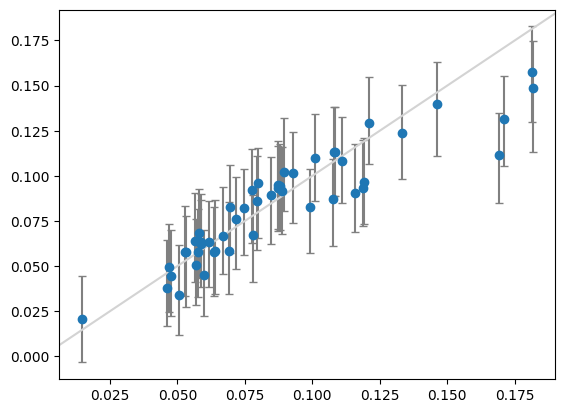

In [29]:
#PREDICTION INTERVAL

from mapie.regression import MapieRegressor

# Train model
best_params = { #STRAINRATE
    'colsample_bytree': 1,
    'gamma': 0,
    'learning_rate': 0.3,
    'max_depth': 2,
    'min_child_weight': 1,
    'n_estimators': 19,
    'subsample': 1}
#setup model
features = input_variable_combination['resultants'] #CHANGE EACH FEATURE SET #'resultants','rotational_components','components'
X = raw_data[features] #make sure this is the correct feature set, as will be set to last iteration from xgboost for loops above!!
y = raw_data['Strain rate 90th%']
kfold = KFold(n_splits=5, shuffle=True, random_state=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

###############################################################################

est = xgb.XGBRegressor(**best_params) # MODEL (tuned)
mapie = MapieRegressor(est, cv=5, agg_function="median")
mapie.fit(X_train, y_train)
y_test_pred, y_test_pis = mapie.predict(X_test, alpha=[0.05])

# Plot the data with the error bars
y_err = np.abs(y_test_pis[:, :, 0].T - y_test_pred)
plt.errorbar(y_test, y_test_pred, yerr=y_err, fmt="o", ecolor="gray", capsize=3)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)

# Print out statistics
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mae_test:.3f}")
print(f"Width of 95% prediction interval: {np.mean(y_err) * 2:3f}")
coverage = regression_coverage_score(y_test, y_test_pis[:, 0, 0], y_test_pis[:, 1, 0])
print(f"Coverage: {coverage:.3f}")
scores = cross_val_score(est,X, y, cv=kfold)
print('r2:', (scores))
print('r2 mean:',sum(scores)/5)
#train_test_score = cross_validate(est,X,y,cv=kfold,return_train_score=True)
#print(train_test_score)

In [10]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score

# Ensure raw_data and input_variable_combination are defined somewhere in your code

# Define the best parameters
best_params = {
    'lambda': 0.1,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'subsample': 0.7,
    'early_stopping_rounds': 7
}

# Setup model
features = input_variable_combination['resultants']  # CHANGE EACH FEATURE SET 'resultants','rotational_components','components'
X = raw_data[features]  # Make sure this is the correct feature set
y = raw_data['Strain rate 90th%']
kfold = KFold(n_splits=5, shuffle=True, random_state=3)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

# Further split the training set into training and validation sets
X_train_inner, X_val, y_train_inner, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=3)

# Initialize the model
est = xgb.XGBRegressor(**best_params)  # MODEL (tuned)
mapie = MapieRegressor(est, cv=kfold, agg_function="median")

# Fit the model with validation data for early stopping
mapie.fit(X_train_inner, y_train_inner, 
          estimator__eval_set=[(X_val, y_val)], 
          estimator__early_stopping_rounds=best_params['early_stopping_rounds'],
          estimator__verbose=True)

# Predict with prediction intervals
y_test_pred, y_test_pis = mapie.predict(X_test, alpha=[0.05])

# Calculate error for plotting
y_err = np.abs(y_test_pis[:, :, 0].T - y_test_pred)

# Plot the data with the error bars
plt.errorbar(y_test, y_test_pred, yerr=y_err, fmt="o", ecolor="gray", capsize=3)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Prediction Interval")
plt.show()

# Print out statistics
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE: {mae_test:.3f}")
print(f"Width of 95% prediction interval: {np.mean(y_err) * 2:.3f}")

coverage = regression_coverage_score(y_test, y_test_pis[:, 0, 0], y_test_pis[:, 1, 0])
print(f"Coverage: {coverage:.3f}")

# Evaluate cross-validation scores
scores = cross_val_score(est, X, y, cv=kfold)
print('r2:', scores)
print('r2 mean:', np.mean(scores))

train_test_score = cross_validate(est, X, y, cv=kfold, return_train_score=True)
print(train_test_score)


TypeError: fit() got an unexpected keyword argument 'estimator__eval_set'

In [ ]:
#EXPORTING BEST MODELS